# 분석 과정

- 전처리 (preprocess)
- 변수선택 (permutation process)
- 모델링 (training)
- 예측 (prediction)
- 사후처리 (postprocess)

## training부분만 생략해주시면 됩니다

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

# Load data

In [ ]:
train = pd.read_csv('../data/.train/.task147/train.csv', index_col=0)
test = pd.read_csv('../data/.train/.task147/test.csv', index_col=0)
sample_submission = pd.read_csv('../data/.train/.task147/sample_submission.csv')

In [ ]:
# numeric column, dummy column만 추출하기 위해 잠깐 train test를 합쳤습니다.
df = train.append(test)

In [ ]:
numeric_col = pd.Series([i[0:2] for i in df.columns]).isin(['va'])
numeric_col = df.columns[numeric_col]

dummy_col = pd.Series([i[0:3] for i in df.columns]).isin(['dum'])
dummy_col = df.columns[dummy_col]

In [ ]:
nudummy_col = ['va08', 'va09','va10','va11','va14','va15','va16','va17','va18','va19','va20','va21','va29','va30','va31','va32','va34']

In [ ]:
train.drop(['dum_3_3','dum_4_1'], axis=1, inplace=True)
test.drop(['dum_3_3','dum_4_1'], axis=1, inplace=True)

In [ ]:
dummy_col = dummy_col.drop(['dum_3_3','dum_4_1'])

In [ ]:
numeric_col = numeric_col.drop(nudummy_col)

In [ ]:
print(dummy_col) # category
print(numeric_col) # numeric
print(nudummy_col) # numeric, but have only two cases

# preprocess

In [ ]:
# 기존의 one hot encoding되어있던 변수를 하나의 dummy변수로 바꿔주는 코드
def dummy_to_origincol(Data_input, dum_name):
    Data = Data_input.copy()
    idx = Data.columns[Data.columns.str.find(dum_name) == 0]
    Data_temp = Data[idx].copy()
    for n, col in enumerate(Data_temp.columns):
        n = n+1
        Data_temp[col] = Data_temp[col]*n
    return Data_temp.sum(axis=1)

In [ ]:
from sklearn.preprocessing import QuantileTransformer
quantile = QuantileTransformer(output_distribution='normal', random_state=42)

def preprocess(train_input,test_input, model_type, scale_type=None):

    train = train_input.copy()
    test = test_input.copy()        
    #Data = train_input.append(test_input)
    #Data = Data.reset_index(drop=True)
    
    #if model_type == 'boosting' or model_type == 'linear':
    
    if scale_type == 'quantile':
        quantile.fit(train[numeric_col])
        train[numeric_col] = quantile.transform(train[numeric_col]) 
        test[numeric_col] = quantile.transform(test[numeric_col])

    if scale_type == 'minmax':
        scaler.fit(train[numeric_col])
        train[numeric_col] = scaler.transform(train[numeric_col])*10
        test[numeric_col] = scaler.transform(test[numeric_col])*10    
    
    # 최종적으로 사용한 scaling : None
    if scale_type == None:
        pass
        #for col in ['va01']:
           
        #    bins = create_bins(lower_bound=0,
        #           width=50,
        #           quantity=50)
        #    bins2 = pd.IntervalIndex.from_tuples(bins)
        #    bins_train = pd.cut(train[col], bins2)
        #    bins_test = pd.cut(test[col], bins2)
        #    encoding = pd.DataFrame(bins_train).groupby(col).size()/len(train)
        #    train[col + "freq"] = bins_train.apply(lambda x : encoding[x])
        #    test[col + "freq"] = bins_train.apply(lambda x : encoding[x])            
    ## boosting model
    
    # one hot encoding된 dummy변수를 lgbm의 cat_features에 사용하기 위해서 바꿔주는 과정
    if model_type == 'boosting':
        for col in ['dum_1', 'dum_2','dum_3','dum_4']:
            dum_tr = dummy_to_origincol(train, col).reset_index(drop=True)
            dum_te = dummy_to_origincol(test, col).reset_index(drop=True)            
            
            train[col] = np.array(dum_tr)
            test[col] = np.array(dum_te)
           
     # va05(연식으로 추정)변수만 train에서 frequency를 계산하여 test에 적용
    for col in ['va05']:
        try:
            encoding = train[numeric_col].groupby(col).size() / len(train)
            train[col + "freq_encode"] = train[col].apply(lambda x : encoding[x])
            test[col + "freq_encode"] = test[col].apply(lambda x : encoding[x])         
        except:
            pass
       
    ## square of numeric col
    # 변수의 의미를 모르기에 단순히 연속형 변수를 2~10제곱으로 파생변수 생성
    for i, num in enumerate([2, 3, 4, 5, 6, 7, 8, 9, 10]):        
        square = train[numeric_col]**(num)        
        square.columns = numeric_col + "_" + str(i) + "sq"    
        train[square.columns] = square
        
        square = test[numeric_col]**(num)        
        square.columns = numeric_col + "_" + str(i) + "sq"    
        test[square.columns] = square    
    
    return train.drop('ad_periods', axis=1), train['ad_periods'], test
    
    ## 샘플 버전
    #return Data, train_input.append(test_input)['ad_periods']

In [ ]:
def rmse2(y_true, y_pred):
    y_true[y_true < 0] = 0
    y_pred[y_pred < 0] = 0
    return 'rmse2', np.sqrt(((y_pred - y_true)**2).mean()) , False

In [ ]:
def custom_RMSE(y_true, y_pred):
    residual = (y_pred - y_true)  
    grad = residual
    hess = np.ones(len(y_true))
    return grad, hess

In [ ]:
import lightgbm as lgbm
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import TimeSeriesSplit
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

seed = 42

def my_lgb(X_train, y_train, param, X_te, fold_n, seed_n, param_type):
    val_save = y_train.copy()
    val_save.iloc[:,] = 0 
    test_save = np.zeros((len(test, )))
    print(len(test_save))
    
    for n_fold, (trn_idx, val_idx) in enumerate(mskf.split(X_train, bins3)):
        print(trn_idx)
        print(val_idx)
        
        trn_x, trn_y = X_train.iloc[trn_idx], y_train.iloc[trn_idx]
        val_x, val_y = X_train.iloc[val_idx], y_train.iloc[val_idx]
        
        reg = lgbm.LGBMRegressor(**param)
        reg.fit(trn_x, trn_y, eval_set=[(trn_x, trn_y), (val_x, val_y)],
                      verbose=True, 
                      eval_metric=lambda y_true, y_pred, integer: [rmse2(y_true, y_pred)],
                      early_stopping_rounds=100)     
        if param_type == None:
            save_path = '/home/workspace/user-workspace/중고차KB/'+'lgb_'+str(fold_n)+'_'+str(seed_n)+'_fold'+str(n_fold)+'.txt'
            reg.booster_.save_model(save_path)
            reg = lgbm.Booster(model_file='/home/workspace/user-workspace/중고차KB/'+'lgb_'+str(fold_n)+'_'+str(seed_n)+'_fold'+str(n_fold)+'.txt')
        elif param_type == 'second':
            save_path = '/home/workspace/user-workspace/중고차KB/'+'lgb3_'+str(fold_n)+'_'+str(seed_n)+'_fold'+str(n_fold)+'.txt'
            reg.booster_.save_model(save_path)
            reg = lgbm.Booster(model_file='/home/workspace/user-workspace/중고차KB/'+'lgb3_'+str(fold_n)+'_'+str(seed_n)+'_fold'+str(n_fold)+'.txt')
                
        val_save.iloc[val_idx,] += reg.predict(val_x)
        pred_temp = reg.predict(X_te)
        test_save += pred_temp/fold_n
        
    
    return val_save, test_save

In [ ]:
def create_bins(lower_bound, width, quantity):   

    bins = []
    for low in range(lower_bound, 
                     lower_bound + quantity*width + 1, width):
        bins.append((low, low+width))
    return bins

bins = create_bins(lower_bound=-1,
                   width=10,
                   quantity=50)
bins2 = pd.IntervalIndex.from_tuples(bins)
bins3 = pd.cut(train['ad_periods'], bins2)
bins3 = pd.get_dummies(bins3)

# Permutation (feature selection)

In [ ]:
param = {'objective':'poisson', 'n_estimators':15000, 'learning_rate':0.05,'random_state':42,
        'early_stopping_round':100,'colsample_bytree':0.8,'metric':'rmse2'} 

#param_xgb = {'objective':'reg:linear','n_estimators':10000, 'learning_rate':0.1,'random_state':42,
#        'early_stopping_rounds':50,'colsample_bytree':0.8, 'metric':'l1', 'tree_method':'gpu_hist'} 


def my_permutation_badfeatures(X_train, y_train):
    y_train_temp = y_train.copy()
    threshold = [0.1, 0.01, 0.001]
    bad_features1 = []
    bad_features2 = []
    bad_features3 = []
        
    def score(X, y):
        y_pred = reg.predict(X)
        return np.sqrt(((y-y_pred)**2).mean())
    
    for n_fold, (trn_idx, val_idx) in enumerate(mskf.split(X_train, bins3)):
        trn_x, trn_y = X_train.iloc[trn_idx], y_train_temp.iloc[trn_idx]
        val_x, val_y = X_train.iloc[val_idx], y_train_temp.iloc[val_idx]
        
        #lgbm 
        reg = lgbm.LGBMRegressor(**param)
        reg.fit(trn_x, trn_y, eval_set=[(trn_x, trn_y), (val_x, val_y)],
                      verbose=True, eval_metric=lambda y_true, y_pred, integer: [rmse2(y_true, y_pred)],
                      early_stopping_rounds=100)
        
        
        
        base_score, score_decreases = get_score_importances(score,np.array(val_x), np.array(val_y), n_iter=3, random_state=42)
        
        bad_features1.extend(list(val_x.columns[score_decreases[0] > -threshold[0]]))
        bad_features2.extend(list(val_x.columns[score_decreases[0] > -threshold[1]]))
        bad_features3.extend(list(val_x.columns[score_decreases[0] > -threshold[2]]))
                             
    return bad_features1, bad_features2, bad_features3

In [ ]:
#from eli5.permutation_importance import get_score_importances
#mskf = MultilabelStratifiedKFold(n_splits=5, random_state=42, shuffle=True)

#X_tr, T, X_te = preprocess(train, test, None, None)
#bad_features1n, bad_features2n, bad_features3n = my_permutation_badfeatures(X_tr, T)

In [ ]:
#pd.Series(bad_features1n).value_counts().to_csv("/home/workspace/user-workspace/중고차KB/bad_features1n.csv")
#pd.Series(bad_features2n).value_counts().to_csv("/home/workspace/user-workspace/중고차KB/bad_features2n.csv")
#pd.Series(bad_features3n).value_counts().to_csv("/home/workspace/user-workspace/중고차KB/bad_features3n.csv")

# Training (이 부분은 생략해주시면 됩니다. training 과정입니다)

In [ ]:
X_tr, T, X_te = preprocess(train, test, 'boosting', None)

In [ ]:
bad_featuresn = pd.read_csv("/home/workspace/user-workspace/중고차KB/bad_features1n.csv", index_col=0)
bad_featuresn = bad_featuresn[bad_featuresn['0'] >= 5]

In [ ]:
np.where(X_tr.drop(bad_featuresn.index, axis=1).columns.isin(['dum_1','dum_2', 'dum_3', 'dum_4', 'va05']) == 1)[0]

In [ ]:
valid_score = T.copy()
valid_score.iloc[:,] = 0 
test_score = np.zeros((len(X_te, )))
seed_list = [24, 24**2, 24**3]

for seed_num in seed_list:
    
    ## param 1##
    ############
    # 5fold
    
    mskf = MultilabelStratifiedKFold(n_splits=5, random_state=seed_num, shuffle=True)
    param = {'objective':'poisson', 'n_estimators':30000, 'learning_rate':0.03,'random_state':seed_num,
        'early_stopping_round':100,'colsample_bytree':0.5,'metric':'rmse2','categorical_feature':[3, 20, 21, 22, 23],
            'lambda_l1':1, 'lambda_l2':1} 
    
    val_pred, pred = my_lgb(X_tr.drop(bad_featuresn.index, axis=1)
                            , T, param, X_te.drop(bad_featuresn.index, axis=1),
                           fold_n=5, seed_n=seed_num, param_type='second')
    valid_score += val_pred/len(seed_list)
    test_score += pred/len(seed_list) 
    
    # 10 fold    
    mskf = MultilabelStratifiedKFold(n_splits=10, random_state=seed_num, shuffle=True)
    val_pred, pred = my_lgb(X_tr.drop(bad_featuresn.index, axis=1), T, param, X_te.drop(bad_featuresn.index, axis=1),
                           fold_n=10, seed_n=seed_num, param_type='second')
    valid_score += val_pred/len(seed_list)
    test_score += pred/len(seed_list)
    
    ## param 2##
    ############
    # 5fold
    mskf = MultilabelStratifiedKFold(n_splits=5, random_state=seed_num, shuffle=True)
    param = {'objective':'poisson', 'n_estimators':30000, 'learning_rate':0.03,'random_state':seed_num,
        'early_stopping_round':100,'colsample_bytree':0.5,'metric':'rmse2','categorical_feature':[3, 20, 21, 22, 23]}
    
    val_pred, pred = my_lgb(X_tr.drop(bad_featuresn.index, axis=1)
                            , T, param, X_te.drop(bad_featuresn.index, axis=1),
                           fold_n=5, seed_n=seed_num, param_type=None)
    valid_score += val_pred/len(seed_list)
    test_score += pred/len(seed_list) 
    
    # 10 fold    
    mskf = MultilabelStratifiedKFold(n_splits=10, random_state=seed_num, shuffle=True)
    val_pred, pred = my_lgb(X_tr.drop(bad_featuresn.index, axis=1), T, param, X_te.drop(bad_featuresn.index, axis=1),
                           fold_n=10, seed_n=seed_num, param_type=None)
    valid_score += val_pred/len(seed_list)
    test_score += pred/len(seed_list)
    

In [ ]:
valid_score = valid_score/2
test_score = test_score/2

In [ ]:
np.sqrt(((T - (valid_score))**2).mean())

# prediction (재현시 여기부터 시행해주시면 됩니다)

In [ ]:
X_tr, T, X_te = preprocess(train, test, 'boosting', None)

In [ ]:
bad_featuresn = pd.read_csv("/home/workspace/user-workspace/중고차KB/bad_features1n.csv", index_col=0)
bad_featuresn = bad_featuresn[bad_featuresn['0'] >= 5]

In [ ]:
from tqdm import tqdm

In [ ]:
pred_final = np.zeros((len(test, )))

for fold_n in [5, 10]:
    for seed_n in tqdm([24, 24**2, 24**3]):
        for n_fold in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
            try:
                model = lgbm.Booster(model_file='/home/workspace/user-workspace/중고차KB/'+'lgb3_'+str(fold_n)+'_'+str(seed_n)+'_fold'+str(n_fold)+'.txt')
                pred_final += model.predict(X_te.drop(bad_featuresn.index, axis=1))/(90)
                model = lgbm.Booster(model_file='/home/workspace/user-workspace/중고차KB/'+'lgb_'+str(fold_n)+'_'+str(seed_n)+'_fold'+str(n_fold)+'.txt')
                pred_final += model.predict(X_te.drop(bad_featuresn.index, axis=1))/(90)               
                
            except:
                pass
pred_final[pred_final < 0] = 0

In [ ]:
plt.hist(pred_final, bins=100)
plt.tight_layout()

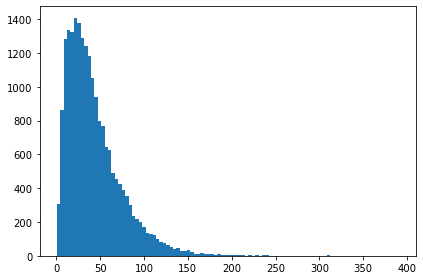

# Post process

In [ ]:
# objective를 poisson으로 해도 prediction의 분포가 Target의 분포와 차이가 있습니다.
# 이를 조금 보정해주고자 작은값에 빼주고, 큰값은 누적해서 더해줬습니다.
# 조금 더 좋은 postprocessing이 있겠지만 단순히 이렇게 해도 cv, lb에 상승이 있어 시행하였습니다.
def post_process(Data_input):
    Data = Data_input.copy()
    Data[Data < 30] = Data[Data < 30] - 1
    Data[Data < 0] = 0
    
    Data[Data >= 50] = Data[Data >= 50] + np.exp(0.1)
    Data[Data >= 60] = Data[Data >= 60] + np.exp(0.15)
    Data[Data >= 80] = Data[Data >= 80] + np.exp(0.2)
    Data[Data >= 100] = Data[Data >= 100] + np.exp(0.25)
    Data[Data >= 150] = Data[Data >= 150] + np.exp(0.3)
    return Data

In [ ]:
pred_final_postprocess = post_process(pd.Series(pred_final))

In [ ]:
plt.hist(np.array(pred_final_postprocess), bins=100, density=True, alpha=0.5)
plt.hist(train['ad_periods'], bins=100, density=True, alpha=0.5)
plt.tight_layout()

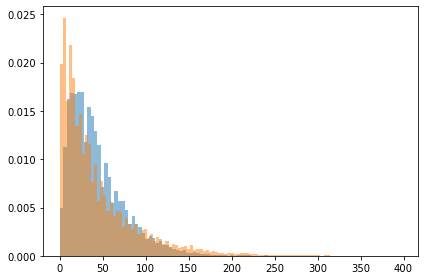

In [ ]:
sample_submission['ad_periods'] = pred_final_postprocess
sample_submission.to_csv('/home/workspace/user-workspace/prediction/prediction.csv', index=False)

# submit

In [ ]:
import os
from nipa.taskSubmit import nipa_submit

team_id = "1192"
task_no= "147"
prediction_path = '/home/workspace/user-workspace/prediction/prediction.csv'
# 파일 존재 여부 확인
print("is file: ", os.path.isfile(prediction_path))

# 제출 성공
nipa_submit(team_id=team_id,
task_no=task_no,
result=prediction_path
)